In [20]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
from tqdm.notebook import tqdm

# --- 实验设置 ---
T = 10000                 
TARGET_ALPHA = 0.1       

# --- 原版 ACI (固定 γ) ---
GAMMA_FIXED = 0.05  

# --- 我们的 ACI-CF (动态 γ_t) ---
GAMMA_MIN = 0.01
GAMMA_MAX = 0.15

WINDOW_SIZE = 100        # 用于 error gap / local error

# --- 基础状态 ---
STATE_A_MU = 0.0         # “中心”分布
STATE_A_ID = 0           


rng = np.random.default_rng(42)

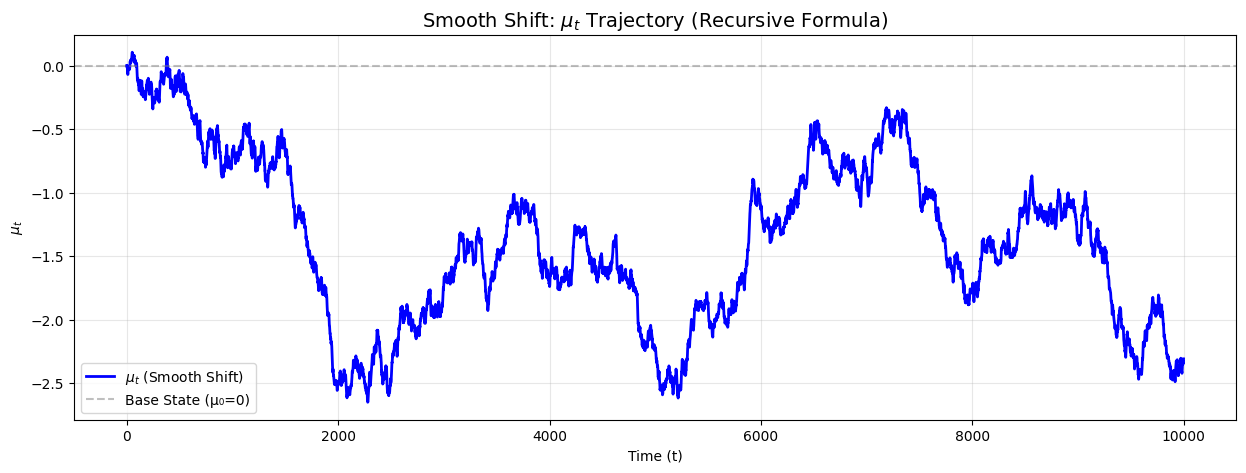

mu_trajectory statistics:
  Mean: -1.3866
  Std: 0.6482
  Min: -2.6509
  Max: 0.1054


In [21]:
# ====================================================
# 使用递归公式重新生成 mu_trajectory（平滑 shift 设置）
# μ₀ = 0
# μ_{t+1} = μ_t + (1/2)(μ_t - μ_{t-1}) + (1/2)ε_t
# 其中 {ε_t} ~ N(0, 0.006)
# ====================================================

# 初始化 mu_trajectory
mu_trajectory = np.zeros(T)
mu_trajectory[0] = STATE_A_MU  # μ₀ = 0

# 生成噪声项 {ε_t} ~ N(0, 0.006)
EPSILON_VAR = 0.0005
epsilon = rng.normal(loc=0.0, scale=np.sqrt(EPSILON_VAR), size=T)

# 递归生成 μ_t
# 对于 t=0: μ₀ = 0 (已设置)
# 初始值
mu_trajectory[0] = 0.0

# 递归生成 μ_t
for t in range(1, T-1):
    mu_trajectory[t+1] = mu_trajectory[t] + 0.5 * (mu_trajectory[t] - mu_trajectory[t-1]) + 0.5 * epsilon[t]

# 可视化生成的 mu_trajectory
plt.figure(figsize=(15, 5))
plt.plot(mu_trajectory, label="$\mu_t$ (Smooth Shift)", color='blue', linewidth=2)
plt.axhline(STATE_A_MU, color='gray', linestyle='--', alpha=0.5, label='Base State (μ₀=0)')
plt.title("Smooth Shift: $\mu_t$ Trajectory (Recursive Formula)", fontsize=14)
plt.xlabel("Time (t)")
plt.ylabel("$\mu_t$")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"mu_trajectory statistics:")
print(f"  Mean: {mu_trajectory.mean():.4f}")
print(f"  Std: {mu_trajectory.std():.4f}")
print(f"  Min: {mu_trajectory.min():.4f}")
print(f"  Max: {mu_trajectory.max():.4f}")


In [22]:
# --- 我们的"固定"模型 (CF/Q_hat) ---
# 我们的模型始终错误地认为数据来自 N(0, 1) [cite: 1574]
# "z_q" 是 N(0, 1) 的 q 分位数
def get_model_quantile(q):
    return st.norm.ppf(q)

# --- 真实世界 (HMM) ---
# 真实世界知道 μ_t，我们的模型不知道

# 1. 真实世界的 "理想" α* (Ground Truth)
# 理论推导：
#   - 模型认为数据来自 N(0, 1)，使用分位数 q = Φ^{-1}(1 - α*)
#   - 真实数据来自 N(μ_t, 1)
#   - 我们希望 P(Y > q) = target_alpha
#   
#   如果真实分布是 N(μ_t, 1)，那么：
#   P(Y > q) = 1 - Φ(q - μ_t) = target_alpha
#   所以：Φ(q - μ_t) = 1 - target_alpha
#   q - μ_t = Φ^{-1}(1 - target_alpha) = z_{1-target_alpha}
#   q = z_{1-target_alpha} + μ_t
#   
#   模型的分位数是：q = Φ^{-1}(1 - α*) = z_{1-α*}
#   所以：z_{1-α*} = z_{1-target_alpha} + μ_t
#   
#   因此：α* = 1 - Φ(z_{1-target_alpha} + μ_t)
def get_true_alpha_star(mu_t, target_alpha):
    z_target = st.norm.ppf(1.0 - target_alpha)  # z_{1-target_alpha}
    # α* = 1 - Φ(z_target + μ_t)
    alpha_star = 1.0 - st.norm.cdf(z_target + mu_t)
    return alpha_star

# 2. 真实世界的 "Y_t"
def get_true_y(mu_t):
    return np.random.normal(loc=mu_t, scale=1.0)

In [23]:
# 先构造一个 "drift 强度" Φ_t（比如距离中心的绝对值）
phi_t = np.abs(mu_trajectory - STATE_A_MU)

# 把 Φ_t 映射到 [0,1] 方便控制
phi_min = np.percentile(phi_t, 5)
phi_max = np.percentile(phi_t, 95)
phi_norm = (np.clip(phi_t, phi_min, phi_max) - phi_min) / (phi_max - phi_min + 1e-8)

# 定义一个简单的 α*_t：越“远离中心”，α* 越低
ALPHA_HIGH = TARGET_ALPHA      # 比如 0.1
ALPHA_LOW  = 0.02              # drift 很大时的最低 α*
alpha_star_trajectory = ALPHA_HIGH - (ALPHA_HIGH - ALPHA_LOW) * phi_norm

验证 alpha* 公式:
当 mu_t = 0 时，alpha* = 0.1000 (应该接近 0.1)
当 mu_t = -2 时，alpha* = 0.7638 (应该 > 0.1)
当 mu_t = 2 时，alpha* = 0.0005 (应该 < 0.1)



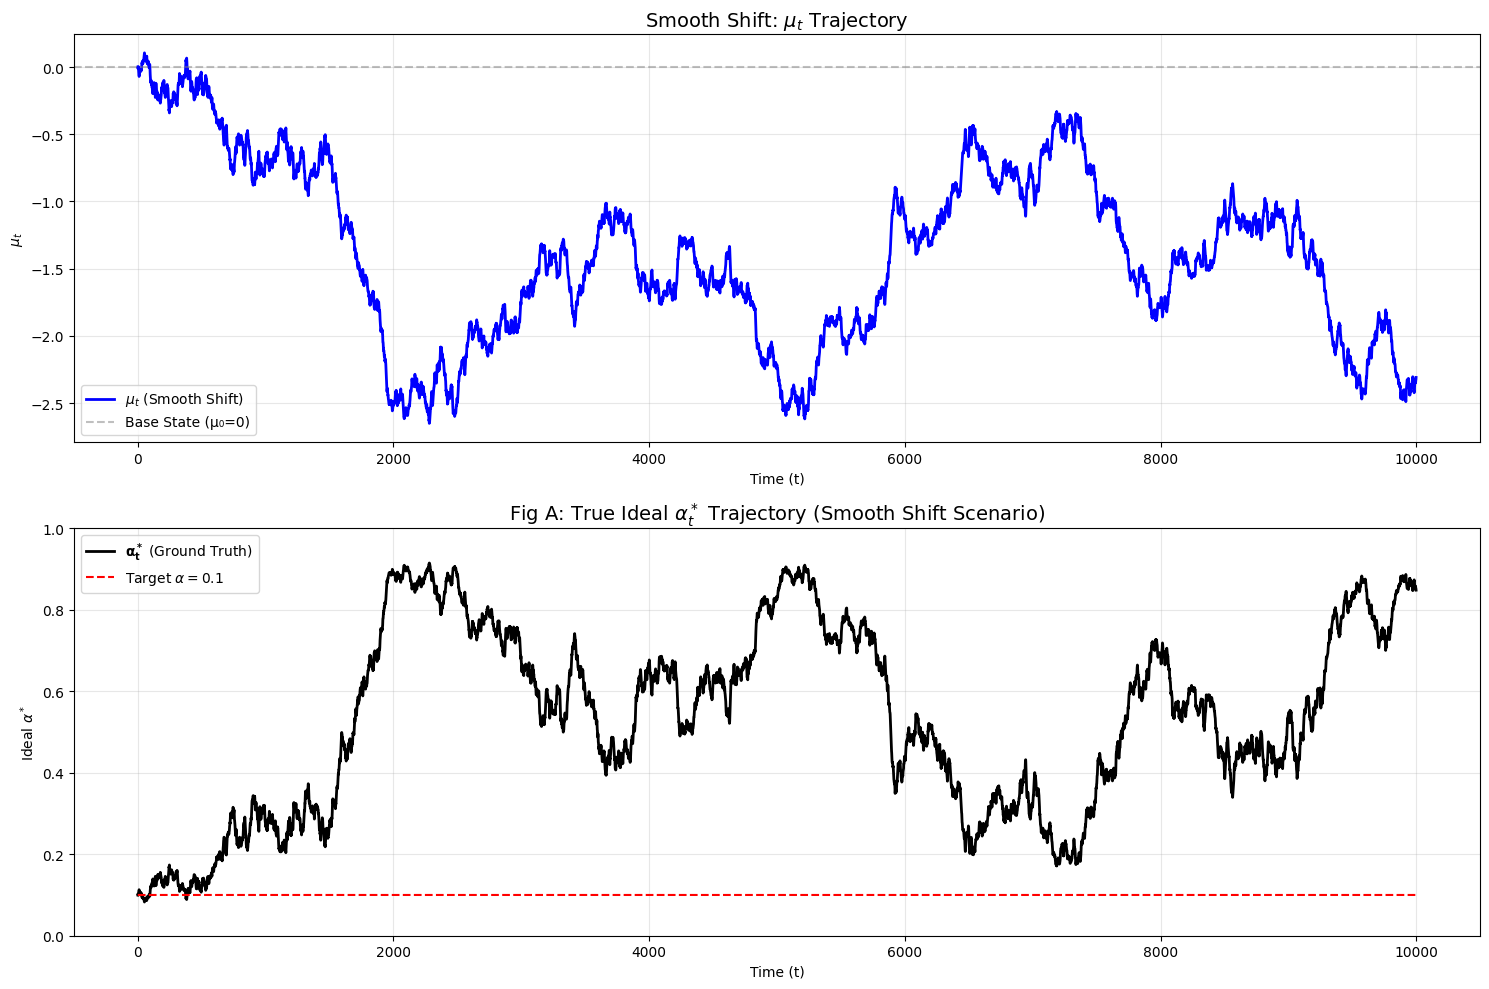

alpha_star_trajectory statistics:
  Mean: 0.5362
  Std: 0.2246
  Min: 0.0827
  Max: 0.9146
  Range check: [0.0827, 0.9146] (should be in [0, 1])


In [24]:
# ====================================================
# 重新计算 alpha_star_trajectory（使用正确的理论公式）
# 使用理论公式：α* = 1 - Φ(z_{1-target_alpha} + μ_t)
# 这个公式确保 α* 始终在 [0, 1] 范围内
# ====================================================

# 验证公式：测试几个mu_t值
print("验证 alpha* 公式:")
print(f"当 mu_t = 0 时，alpha* = {get_true_alpha_star(0.0, TARGET_ALPHA):.4f} (应该接近 {TARGET_ALPHA})")
print(f"当 mu_t = -2 时，alpha* = {get_true_alpha_star(-2.0, TARGET_ALPHA):.4f} (应该 > {TARGET_ALPHA})")
print(f"当 mu_t = 2 时，alpha* = {get_true_alpha_star(2.0, TARGET_ALPHA):.4f} (应该 < {TARGET_ALPHA})")
print()

# 计算每一步的 "理想 α*" (Ground Truth)
alpha_star_trajectory = np.zeros(T)
for t in range(T):
    alpha_star_trajectory[t] = get_true_alpha_star(mu_trajectory[t], TARGET_ALPHA)

# 确保 alpha_star 在 [0, 1] 范围内（理论上应该已经是，但为了安全起见）
alpha_star_trajectory = np.clip(alpha_star_trajectory, 0.0, 1.0)

# 可视化 mu_trajectory 和 alpha_star_trajectory
target_alpha_array = np.full(T, TARGET_ALPHA)

plt.figure(figsize=(15, 10))

# 上图：mu_trajectory
plt.subplot(2, 1, 1)
plt.plot(mu_trajectory, label="$\mu_t$ (Smooth Shift)", color='blue', linewidth=2)
plt.axhline(STATE_A_MU, color='gray', linestyle='--', alpha=0.5, label='Base State (μ₀=0)')
plt.title("Smooth Shift: $\mu_t$ Trajectory", fontsize=14)
plt.xlabel("Time (t)")
plt.ylabel("$\mu_t$")
plt.legend()
plt.grid(True, alpha=0.3)

# 下图：alpha_star_trajectory
plt.subplot(2, 1, 2)
plt.plot(alpha_star_trajectory, label="$\mathbf{\\alpha_t^*}$ (Ground Truth)", color='black', linewidth=2)
plt.plot(target_alpha_array, label=f"Target $\\alpha={TARGET_ALPHA}$", linestyle='--', color='red')
plt.title("Fig A: True Ideal $\\alpha_t^*$ Trajectory (Smooth Shift Scenario)", fontsize=14)
plt.xlabel("Time (t)")
plt.ylabel("Ideal $\\alpha^*$")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)  # 确保y轴范围在[0,1]

plt.tight_layout()
plt.show()

print(f"alpha_star_trajectory statistics:")
print(f"  Mean: {alpha_star_trajectory.mean():.4f}")
print(f"  Std: {alpha_star_trajectory.std():.4f}")
print(f"  Min: {alpha_star_trajectory.min():.4f}")
print(f"  Max: {alpha_star_trajectory.max():.4f}")
print(f"  Range check: [{alpha_star_trajectory.min():.4f}, {alpha_star_trajectory.max():.4f}] (should be in [0, 1])")


In [25]:
# --- 在 HMM 轨迹上构造一个“oracle OOD 概率” p_t ∈ [0,1] ---

# 以基础状态的均值 STATE_A_MU 为“in-domain 中心”
ood_score = np.abs(mu_trajectory - STATE_A_MU)   # 越远越 OOD

# 归一化到 [0,1]，注意加一个 tiny eps 防止除 0
OOD_MIN = ood_score.min()
OOD_MAX = ood_score.max()
ood_prob = (ood_score - OOD_MIN) / (OOD_MAX - OOD_MIN + 1e-8)

# 检查一下范围
print("ood_prob in [%.3f, %.3f]" % (ood_prob.min(), ood_prob.max()))


ood_prob in [0.000, 1.000]


In [26]:
# === 预生成整条真实轨迹 Y_t，用于 RMD 与 ACI 同时使用 ===

y_full = np.zeros(T)
for t in range(T):
    y_full[t] = get_true_y(mu_trajectory[t])

In [27]:
# === 拟合 in-domain / background 高斯，并计算 1D RMD ===

# 1) 用 "接近基础状态" 的时间步作为 in-domain 样本
#    在drift场景中，我们选择mu_t接近STATE_A_MU的时间步
mu_threshold = 0.2  # 阈值：mu_t距离STATE_A_MU小于这个值认为是in-domain
is_base = np.abs(mu_trajectory - STATE_A_MU) < mu_threshold
z_in = y_full[is_base]
z_bg = y_full  # 背景就用整条轨迹

if len(z_in) == 0:
    # 如果没有足够接近的点，使用前一部分作为in-domain
    in_domain_size = min(500, T // 4)
    z_in = y_full[:in_domain_size]
    print(f"Warning: No points close to base state, using first {in_domain_size} points as in-domain")

mu_in = z_in.mean()
sigma_in = z_in.std(ddof=1)
mu_bg = z_bg.mean()
sigma_bg = z_bg.std(ddof=1)

print("In-domain mean/std:", mu_in, sigma_in)
print("Background mean/std:", mu_bg, sigma_bg)
print(f"In-domain samples: {len(z_in)} / {T}")

# 防止 sigma 非常小
sigma_in = max(sigma_in, 1e-6)
sigma_bg = max(sigma_bg, 1e-6)

# 2) 计算每个时间步的 Mahalanobis 距离和 RMD
md_in = ((y_full - mu_in) / sigma_in)**2
md_bg = ((y_full - mu_bg) / sigma_bg)**2
rmd_raw = md_in - md_bg   # 越大越 OOD（类比 Ren 的 RMD）

# 3) 把 RMD 映射到 [0, 1] 得到 OOD 概率 p_t
#    用分位数做一个稳一点的 min-max，避免极端值
low = np.percentile(rmd_raw, 5)
high = np.percentile(rmd_raw, 95)
rmd_clipped = np.clip(rmd_raw, low, high)
ood_prob = (rmd_clipped - low) / (high - low + 1e-8)

print("ood_prob range:", ood_prob.min(), ood_prob.max())

In-domain mean/std: -0.09124786656310702 0.948495604228312
Background mean/std: -1.4004778408639105 1.1949503996732007
In-domain samples: 424 / 10000
ood_prob range: 0.0 0.9999999991267133


In [28]:
# --- 初始化算法状态 ---
# 1. Baseline (不学习)
alpha_baseline = np.full(T, TARGET_ALPHA)
err_baseline = []

# 2. ACI (固定 γ)
alpha_aci_fixed = np.zeros(T)
alpha_aci_fixed[0] = TARGET_ALPHA
err_aci_fixed = []

# 3. ACI-CF (我们的动态 γ_t)
alpha_aci_ours = np.zeros(T)
alpha_aci_ours[0] = TARGET_ALPHA
err_aci_ours = []
gamma_t_history = [] # 记录我们选择的 γ_t
phi_t_history = []   # 记录真实的 Φ_t (用于验证)
p_t_history = []     # 记录 p_t
p_gap_history = []   # 记录 p_gap
p_rmd_history = []   # 记录 p_rmd

# 初始化 p_rmd (用于 EMA)
p_rmd = ood_prob[0]  # 初始化为第一个值

# --- 模拟 T 步 ---
for t in range(T):
    # 1. 获取当前 "世界" 状态
    mu_t = mu_trajectory[t]
    # x_t = x_trajectory[t]
    alpha_star_t = alpha_star_trajectory[t]
    
    # 2. 观测一个真实的 Y_t
    y_t = get_true_y(mu_t)
    
    # --- 算法 1: Baseline ---
    # Baseline 始终使用 α=0.1
    q_baseline = get_model_quantile(1 - alpha_baseline[t])
    is_error_baseline = 1.0 if y_t > q_baseline else 0.0
    err_baseline.append(is_error_baseline)
    
    # --- 算法 2: ACI (固定 γ) ---
    # 确保alpha在合理范围内 [0, 1]
    alpha_aci_fixed[t] = np.clip(alpha_aci_fixed[t], 0.0, 1.0)
    q_aci_fixed = get_model_quantile(1 - alpha_aci_fixed[t])
    is_error_aci_fixed = 1.0 if y_t > q_aci_fixed else 0.0
    err_aci_fixed.append(is_error_aci_fixed)
    
    # 更新 (下一轮使用)
    if t < T-1:
        alpha_aci_fixed[t+1] = alpha_aci_fixed[t] + GAMMA_FIXED * (TARGET_ALPHA - is_error_aci_fixed)
        # 限制在 [0, 1] 范围内
        alpha_aci_fixed[t+1] = np.clip(alpha_aci_fixed[t+1], 0.0, 1.0)
        
    # --- 算法 3: ACI-CF (我们的动态 γ_t) ---
    # 确保alpha在合理范围内 [0, 1]
    alpha_aci_ours[t] = np.clip(alpha_aci_ours[t], 0.0, 1.0)
    q_aci_ours = get_model_quantile(1 - alpha_aci_ours[t])
    is_error_aci_ours = 1.0 if y_t > q_aci_ours else 0.0
    err_aci_ours.append(is_error_aci_ours)
    
    # (记录真实的 Φ_t 用于验证)
    phi_t = (alpha_aci_ours[t] - alpha_star_t)**2
    phi_t_history.append(phi_t)
    
    # # 1. 用 "近期性能" 计算 S_t (Φ_t 的新代理)
    # if t < WINDOW_SIZE:
    #     s_t = 0.0 # 刚开始，历史数据不足，保持稳定
    # else:
    #     # 计算过去 W 步的平均错误率
    #     recent_avg_error = np.mean(err_aci_ours[t-WINDOW_SIZE : t])
    #     # S_t 是“近期错误率”与“目标错误率”的差距
    #     s_t = np.abs(recent_avg_error - TARGET_ALPHA)
    # # 我们的核心创新：
    # # 2. 用 γ_t* ∝ Φ_t (我们这里用 S_t 作为代理)
    # gamma_t = GAMMA_MIN + C_S * s_t # 线性策略
    # # gamma_t = GAMMA_MIN + C_S * np.sqrt(s_t) # 或者用你slide上的平方根策略
    # gamma_t = np.clip(gamma_t, GAMMA_MIN, GAMMA_MAX)
    # gamma_t_history.append(gamma_t)

    # # 2）极简方案 A：用“OOD 概率” p_t 直接驱动 γ_t
    # p_t = ood_prob[t]  # 这里就是我们在 synthetic 上构造的 oracle OOD 概率，已经在 [0,1]
    # gamma_t = GAMMA_MIN + (GAMMA_MAX - GAMMA_MIN) * p_t
    # gamma_t_history.append(gamma_t)

    # 1) 使用预生成的 y_full
    y_t = y_full[t]
    # 1）用 RMD-based ood_prob[t] 作为 OOD 概率 p_t
    # p_rmd = ood_prob[t]  # ∈ [0,1]
    # RMD EMA
    p_rmd = 0.9 * p_rmd + 0.1 * ood_prob[t]
    # （可选）叠加一个基于 error gap 的信号：
    if t < WINDOW_SIZE:
        avg_err = TARGET_ALPHA
    else:
        avg_err = np.mean(err_aci_ours[t-WINDOW_SIZE+1 : t+1])
    gap_t = abs(avg_err - TARGET_ALPHA)
    GAP_SCALE = 0.1
    p_gap = min(1.0, gap_t / GAP_SCALE)
    # p_t = max(p_rmd, p_gap)
    # p_t = (p_rmd + p_gap)/2
    p_t = p_rmd

    # 2）极简 γ_t：γ_t = γ_min + (γ_max - γ_min) * p_t
    gamma_t = GAMMA_MIN + (GAMMA_MAX - GAMMA_MIN) * p_t
    gamma_t_history.append(gamma_t)
    
    # 记录 p_t, p_gap, p_rmd 的值
    p_t_history.append(p_t)
    p_gap_history.append(p_gap)
    p_rmd_history.append(p_rmd)
    
    # 更新 (下一轮使用)
    if t < T-1:
        alpha_aci_ours[t+1] = alpha_aci_ours[t] + gamma_t * (TARGET_ALPHA - is_error_aci_ours)
        # 限制在 [0, 1] 范围内，防止alpha值超出合理范围
        alpha_aci_ours[t+1] = np.clip(alpha_aci_ours[t+1], 0.0, 1.0)

print("Simulation complete.")

Simulation complete.


In [29]:
# ====================================================
# 运行多次实验以计算置信区间
# ====================================================

def run_single_experiment(seed=None):
    """
    运行一次完整的实验
    
    Returns:
        dict: 包含 alpha_aci_ours, alpha_aci_fixed, alpha_baseline 的字典
    """
    # 使用指定的随机种子
    if seed is not None:
        local_rng = np.random.default_rng(seed)
    else:
        local_rng = np.random.default_rng()
    
    # 重新生成 y_full（每次实验需要不同的随机数据）
    y_full_local = np.zeros(T)
    for t in range(T):
        y_full_local[t] = local_rng.normal(loc=mu_trajectory[t], scale=1.0)
    
    # 重新计算 ood_prob（基于新的 y_full）
    mu_threshold = 0.2
    is_base = np.abs(mu_trajectory - STATE_A_MU) < mu_threshold
    z_in = y_full_local[is_base]
    z_bg = y_full_local
    
    if len(z_in) == 0:
        in_domain_size = min(500, T // 4)
        z_in = y_full_local[:in_domain_size]
    
    mu_in = z_in.mean()
    sigma_in = max(z_in.std(ddof=1), 1e-6)
    mu_bg = z_bg.mean()
    sigma_bg = max(z_bg.std(ddof=1), 1e-6)
    
    md_in = ((y_full_local - mu_in) / sigma_in)**2
    md_bg = ((y_full_local - mu_bg) / sigma_bg)**2
    rmd_raw = md_in - md_bg
    
    low = np.percentile(rmd_raw, 5)
    high = np.percentile(rmd_raw, 95)
    rmd_clipped = np.clip(rmd_raw, low, high)
    ood_prob_local = (rmd_clipped - low) / (high - low + 1e-8)
    
    # --- 初始化算法状态 ---
    alpha_baseline = np.full(T, TARGET_ALPHA)
    alpha_aci_fixed = np.zeros(T)
    alpha_aci_fixed[0] = TARGET_ALPHA
    alpha_aci_ours = np.zeros(T)
    alpha_aci_ours[0] = TARGET_ALPHA
    
    # 初始化 p_rmd (用于 EMA)
    p_rmd = ood_prob_local[0]
    
    # 跟踪错误历史（用于计算p_gap和其他指标）
    err_aci_ours_list = []
    err_aci_fixed_list = []
    err_baseline_list = []
    
    # 跟踪 gamma_t 和 phi_t
    gamma_t_history = []
    phi_t_history = []
    
    # --- 模拟 T 步 ---
    for t in range(T):
        mu_t = mu_trajectory[t]
        alpha_star_t = alpha_star_trajectory[t]
        y_t = y_full_local[t]
        
        # --- 算法 1: Baseline ---
        q_baseline = get_model_quantile(1 - alpha_baseline[t])
        is_error_baseline = 1.0 if y_t > q_baseline else 0.0
        err_baseline_list.append(is_error_baseline)
        
        # --- 算法 2: ACI (固定 γ) ---
        alpha_aci_fixed[t] = np.clip(alpha_aci_fixed[t], 0.0, 1.0)
        q_aci_fixed = get_model_quantile(1 - alpha_aci_fixed[t])
        is_error_aci_fixed = 1.0 if y_t > q_aci_fixed else 0.0
        err_aci_fixed_list.append(is_error_aci_fixed)
        
        if t < T-1:
            alpha_aci_fixed[t+1] = alpha_aci_fixed[t] + GAMMA_FIXED * (TARGET_ALPHA - is_error_aci_fixed)
            alpha_aci_fixed[t+1] = np.clip(alpha_aci_fixed[t+1], 0.0, 1.0)
        
        # --- 算法 3: ACI-CF (我们的动态 γ_t) ---
        alpha_aci_ours[t] = np.clip(alpha_aci_ours[t], 0.0, 1.0)
        q_aci_ours = get_model_quantile(1 - alpha_aci_ours[t])
        is_error_aci_ours = 1.0 if y_t > q_aci_ours else 0.0
        err_aci_ours_list.append(is_error_aci_ours)
        
        # 记录真实的 Φ_t 用于验证
        phi_t = (alpha_aci_ours[t] - alpha_star_t)**2
        phi_t_history.append(phi_t)
        
        # RMD EMA
        p_rmd = 0.9 * p_rmd + 0.1 * ood_prob_local[t]
        
        # 计算 p_t（使用错误历史）
        if t < WINDOW_SIZE:
            avg_err = TARGET_ALPHA
        else:
            avg_err = np.mean(err_aci_ours_list[t-WINDOW_SIZE+1 : t+1])
        gap_t = abs(avg_err - TARGET_ALPHA)
        GAP_SCALE = 0.1
        p_gap = min(1.0, gap_t / GAP_SCALE)
        p_t = p_rmd  # 使用p_rmd，与原始代码保持一致
        
        gamma_t = GAMMA_MIN + (GAMMA_MAX - GAMMA_MIN) * p_t
        gamma_t_history.append(gamma_t)
        
        if t < T-1:
            alpha_aci_ours[t+1] = alpha_aci_ours[t] + gamma_t * (TARGET_ALPHA - is_error_aci_ours)
            alpha_aci_ours[t+1] = np.clip(alpha_aci_ours[t+1], 0.0, 1.0)
    
    return {
        'alpha_aci_ours': alpha_aci_ours.copy(),
        'alpha_aci_fixed': alpha_aci_fixed.copy(),
        'alpha_baseline': alpha_baseline.copy(),
        'err_aci_ours': np.array(err_aci_ours_list),
        'err_aci_fixed': np.array(err_aci_fixed_list),
        'err_baseline': np.array(err_baseline_list),
        'gamma_t_history': np.array(gamma_t_history),
        'phi_t_history': np.array(phi_t_history)
    }


# 运行多次实验
N_EXPERIMENTS = 50  # 实验次数，可以根据需要调整
print(f"Running {N_EXPERIMENTS} experiments...")

# 存储所有实验的结果
results_alpha_aci_ours = []
results_alpha_aci_fixed = []
results_alpha_baseline = []
results_err_aci_ours = []
results_err_aci_fixed = []
results_err_baseline = []
results_gamma_t = []
results_phi_t = []

# 运行多次实验
for i in tqdm(range(N_EXPERIMENTS), desc="Running experiments"):
    result = run_single_experiment(seed=42 + i)  # 使用不同的随机种子
    results_alpha_aci_ours.append(result['alpha_aci_ours'])
    results_alpha_aci_fixed.append(result['alpha_aci_fixed'])
    results_alpha_baseline.append(result['alpha_baseline'])
    results_err_aci_ours.append(result['err_aci_ours'])
    results_err_aci_fixed.append(result['err_aci_fixed'])
    results_err_baseline.append(result['err_baseline'])
    results_gamma_t.append(result['gamma_t_history'])
    results_phi_t.append(result['phi_t_history'])

# 转换为numpy数组，形状为 (N_EXPERIMENTS, T)
results_alpha_aci_ours = np.array(results_alpha_aci_ours)
results_alpha_aci_fixed = np.array(results_alpha_aci_fixed)
results_alpha_baseline = np.array(results_alpha_baseline)
results_err_aci_ours = np.array(results_err_aci_ours)
results_err_aci_fixed = np.array(results_err_aci_fixed)
results_err_baseline = np.array(results_err_baseline)
results_gamma_t = np.array(results_gamma_t)
results_phi_t = np.array(results_phi_t)

# 计算95%置信区间 (使用t分布，因为样本数可能较小)
confidence_level = 0.95
alpha_ci = 1 - confidence_level
t_value = st.t.ppf(1 - alpha_ci/2, df=N_EXPERIMENTS - 1)

# ===== 计算 alpha 的置信区间 =====
mean_aci_ours = np.mean(results_alpha_aci_ours, axis=0)
std_aci_ours = np.std(results_alpha_aci_ours, axis=0, ddof=1)
ci_upper_aci_ours = mean_aci_ours + t_value * std_aci_ours / np.sqrt(N_EXPERIMENTS)
ci_lower_aci_ours = mean_aci_ours - t_value * std_aci_ours / np.sqrt(N_EXPERIMENTS)

mean_aci_fixed = np.mean(results_alpha_aci_fixed, axis=0)
std_aci_fixed = np.std(results_alpha_aci_fixed, axis=0, ddof=1)
ci_upper_aci_fixed = mean_aci_fixed + t_value * std_aci_fixed / np.sqrt(N_EXPERIMENTS)
ci_lower_aci_fixed = mean_aci_fixed - t_value * std_aci_fixed / np.sqrt(N_EXPERIMENTS)

mean_baseline = np.mean(results_alpha_baseline, axis=0)
std_baseline = np.std(results_alpha_baseline, axis=0, ddof=1)
ci_upper_baseline = mean_baseline + t_value * std_baseline / np.sqrt(N_EXPERIMENTS)
ci_lower_baseline = mean_baseline - t_value * std_baseline / np.sqrt(N_EXPERIMENTS)

# ===== 计算 gamma_t 的置信区间 =====
mean_gamma_t = np.mean(results_gamma_t, axis=0)
std_gamma_t = np.std(results_gamma_t, axis=0, ddof=1)
ci_upper_gamma_t = mean_gamma_t + t_value * std_gamma_t / np.sqrt(N_EXPERIMENTS)
ci_lower_gamma_t = mean_gamma_t - t_value * std_gamma_t / np.sqrt(N_EXPERIMENTS)

# ===== 计算 phi_t 的置信区间 =====
mean_phi_t = np.mean(results_phi_t, axis=0)
std_phi_t = np.std(results_phi_t, axis=0, ddof=1)
ci_upper_phi_t = mean_phi_t + t_value * std_phi_t / np.sqrt(N_EXPERIMENTS)
ci_lower_phi_t = mean_phi_t - t_value * std_phi_t / np.sqrt(N_EXPERIMENTS)

# ===== 计算局部错误率的置信区间 =====
LOCAL_WINDOW_SIZE = 50  # 用于计算局部错误率的窗口大小

def compute_local_error_rate(err_array, window_size):
    """计算瞬时局部错误率"""
    local_error_rate = np.zeros(len(err_array))
    for t in range(len(err_array)):
        start_idx = max(0, t - window_size//2)
        local_error_rate[t] = np.mean(err_array[start_idx:t+window_size//2])
    return local_error_rate

# 对每次实验计算局部错误率
local_err_aci_ours_all = []
local_err_aci_fixed_all = []
local_err_baseline_all = []

for i in range(N_EXPERIMENTS):
    local_err_aci_ours_all.append(compute_local_error_rate(results_err_aci_ours[i], LOCAL_WINDOW_SIZE))
    local_err_aci_fixed_all.append(compute_local_error_rate(results_err_aci_fixed[i], LOCAL_WINDOW_SIZE))
    local_err_baseline_all.append(compute_local_error_rate(results_err_baseline[i], LOCAL_WINDOW_SIZE))

local_err_aci_ours_all = np.array(local_err_aci_ours_all)
local_err_aci_fixed_all = np.array(local_err_aci_fixed_all)
local_err_baseline_all = np.array(local_err_baseline_all)

mean_local_err_aci_ours = np.mean(local_err_aci_ours_all, axis=0)
std_local_err_aci_ours = np.std(local_err_aci_ours_all, axis=0, ddof=1)
ci_upper_local_err_aci_ours = mean_local_err_aci_ours + t_value * std_local_err_aci_ours / np.sqrt(N_EXPERIMENTS)
ci_lower_local_err_aci_ours = mean_local_err_aci_ours - t_value * std_local_err_aci_ours / np.sqrt(N_EXPERIMENTS)

mean_local_err_aci_fixed = np.mean(local_err_aci_fixed_all, axis=0)
std_local_err_aci_fixed = np.std(local_err_aci_fixed_all, axis=0, ddof=1)
ci_upper_local_err_aci_fixed = mean_local_err_aci_fixed + t_value * std_local_err_aci_fixed / np.sqrt(N_EXPERIMENTS)
ci_lower_local_err_aci_fixed = mean_local_err_aci_fixed - t_value * std_local_err_aci_fixed / np.sqrt(N_EXPERIMENTS)

mean_local_err_baseline = np.mean(local_err_baseline_all, axis=0)
std_local_err_baseline = np.std(local_err_baseline_all, axis=0, ddof=1)
ci_upper_local_err_baseline = mean_local_err_baseline + t_value * std_local_err_baseline / np.sqrt(N_EXPERIMENTS)
ci_lower_local_err_baseline = mean_local_err_baseline - t_value * std_local_err_baseline / np.sqrt(N_EXPERIMENTS)

# ===== 计算累积平均错误率的置信区间 =====
def compute_cumulative_avg_error(err_array):
    """计算累积平均错误率"""
    cumulative_avg = np.zeros(len(err_array))
    for t in range(len(err_array)):
        cumulative_avg[t] = np.mean(err_array[0:t+1])
    return cumulative_avg

# 对每次实验计算累积平均错误率
cumulative_avg_aci_ours_all = []
cumulative_avg_aci_fixed_all = []
cumulative_avg_baseline_all = []

for i in range(N_EXPERIMENTS):
    cumulative_avg_aci_ours_all.append(compute_cumulative_avg_error(results_err_aci_ours[i]))
    cumulative_avg_aci_fixed_all.append(compute_cumulative_avg_error(results_err_aci_fixed[i]))
    cumulative_avg_baseline_all.append(compute_cumulative_avg_error(results_err_baseline[i]))

cumulative_avg_aci_ours_all = np.array(cumulative_avg_aci_ours_all)
cumulative_avg_aci_fixed_all = np.array(cumulative_avg_aci_fixed_all)
cumulative_avg_baseline_all = np.array(cumulative_avg_baseline_all)

mean_cumulative_avg_aci_ours = np.mean(cumulative_avg_aci_ours_all, axis=0)
std_cumulative_avg_aci_ours = np.std(cumulative_avg_aci_ours_all, axis=0, ddof=1)
ci_upper_cumulative_avg_aci_ours = mean_cumulative_avg_aci_ours + t_value * std_cumulative_avg_aci_ours / np.sqrt(N_EXPERIMENTS)
ci_lower_cumulative_avg_aci_ours = mean_cumulative_avg_aci_ours - t_value * std_cumulative_avg_aci_ours / np.sqrt(N_EXPERIMENTS)

mean_cumulative_avg_aci_fixed = np.mean(cumulative_avg_aci_fixed_all, axis=0)
std_cumulative_avg_aci_fixed = np.std(cumulative_avg_aci_fixed_all, axis=0, ddof=1)
ci_upper_cumulative_avg_aci_fixed = mean_cumulative_avg_aci_fixed + t_value * std_cumulative_avg_aci_fixed / np.sqrt(N_EXPERIMENTS)
ci_lower_cumulative_avg_aci_fixed = mean_cumulative_avg_aci_fixed - t_value * std_cumulative_avg_aci_fixed / np.sqrt(N_EXPERIMENTS)

print(f"Experiments complete! Computed 95% confidence intervals using {N_EXPERIMENTS} runs.")


Running 50 experiments...


Running experiments:   0%|          | 0/50 [00:00<?, ?it/s]

Experiments complete! Computed 95% confidence intervals using 50 runs.


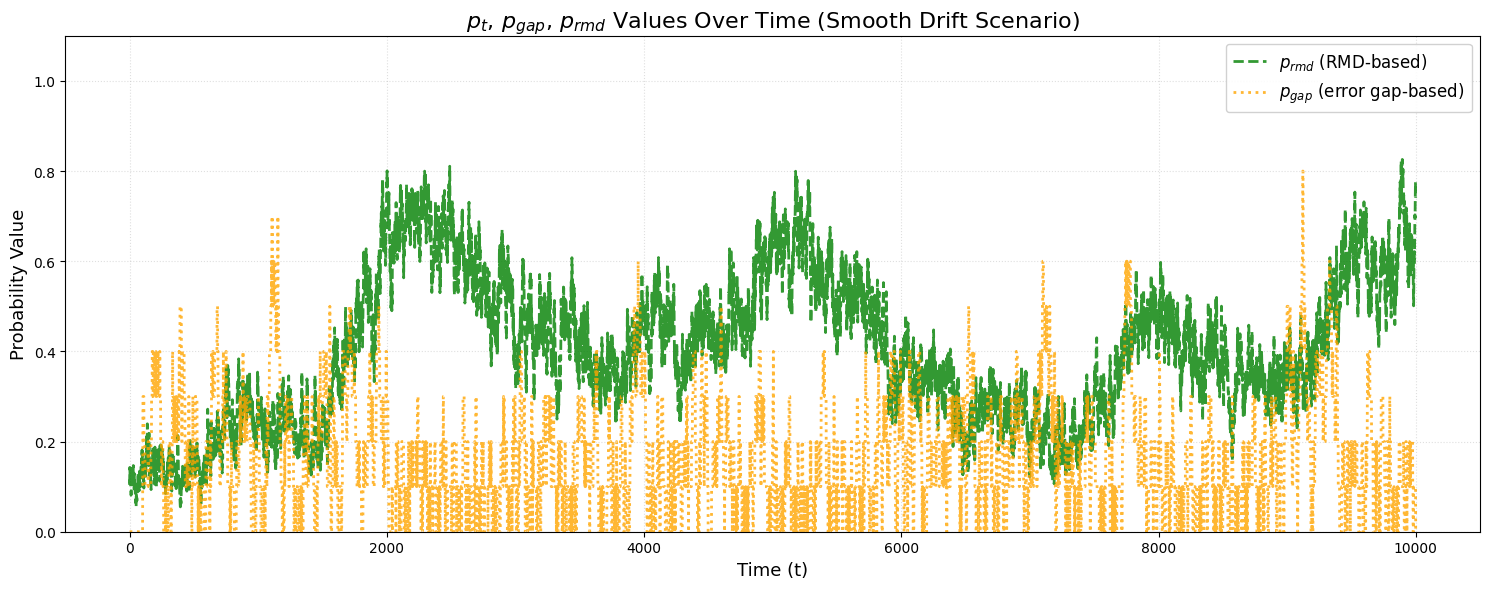

In [30]:
# --- 绘制 p_t, p_gap, p_rmd 的变化图 ---
plt.figure(figsize=(15, 6))
# plt.plot(p_t_history, label='$p_t$ (combined)', color='blue', linewidth=2, alpha=0.9)
plt.plot(p_rmd_history, label='$p_{rmd}$ (RMD-based)', color='green', linewidth=2, alpha=0.8, linestyle='--')
plt.plot(p_gap_history, label='$p_{gap}$ (error gap-based)', color='orange', linewidth=2, alpha=0.8, linestyle=':')

plt.title("$p_t$, $p_{gap}$, $p_{rmd}$ Values Over Time (Smooth Drift Scenario)", fontsize=16)
plt.xlabel("Time (t)", fontsize=13)
plt.ylabel("Probability Value", fontsize=13)
plt.legend(fontsize=12, framealpha=0.9)
plt.grid(True, linestyle=':', alpha=0.4)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()


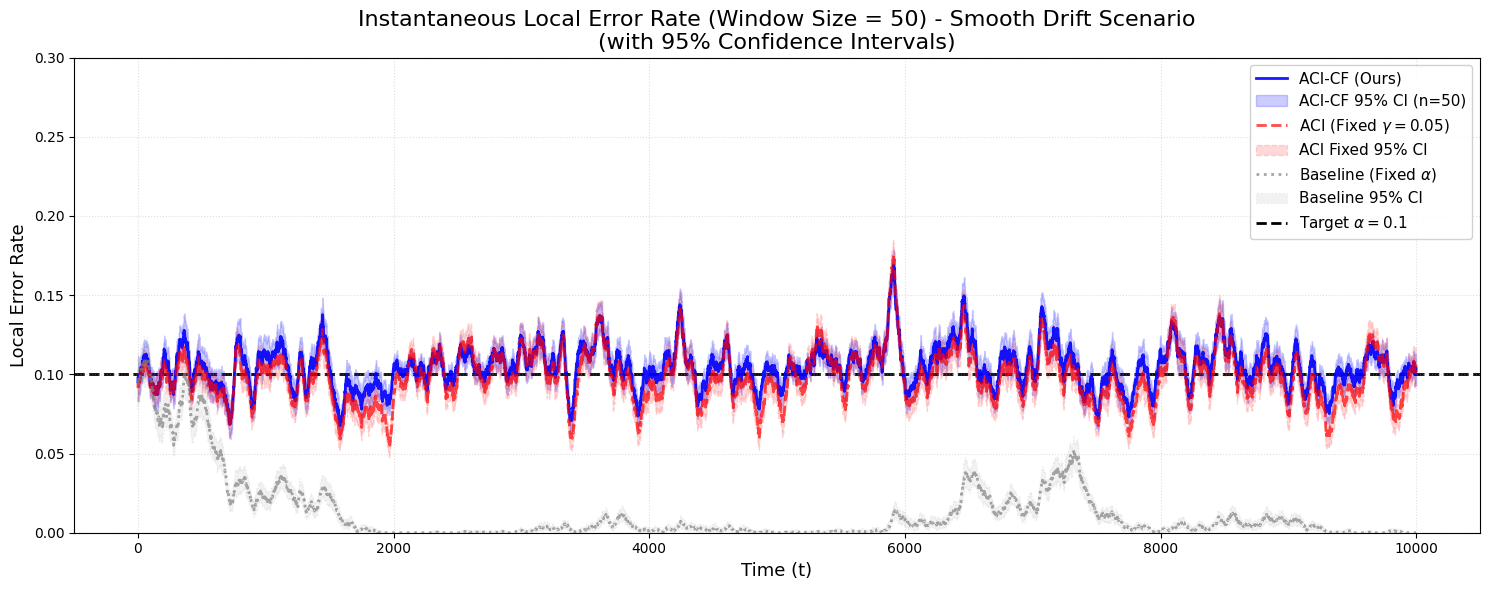

In [ ]:
# --- "Instantaneous Local Error Rate Plot" ---
# 计算瞬时局部错误率（使用滑动窗口）

# 设置滑动窗口大小
LOCAL_WINDOW_SIZE = 50  # 用于计算局部错误率的窗口大小

# 将错误列表转换为numpy数组
err_baseline_arr = np.array(err_baseline)
err_aci_fixed_arr = np.array(err_aci_fixed)
err_aci_ours_arr = np.array(err_aci_ours)

# 计算每个时间点的局部错误率（滑动窗口平均）
def compute_local_error_rate(err_array, window_size):
    """计算瞬时局部错误率"""
    local_error_rate = np.zeros(len(err_array))
    for t in range(len(err_array)):
        # 使用从开始到当前时刻的窗口
        start_idx = max(0, t - window_size//2)
        local_error_rate[t] = np.mean(err_array[start_idx:t+window_size//2])
    return local_error_rate

local_err_baseline = compute_local_error_rate(err_baseline_arr, LOCAL_WINDOW_SIZE)
local_err_aci_fixed = compute_local_error_rate(err_aci_fixed_arr, LOCAL_WINDOW_SIZE)
local_err_aci_ours = compute_local_error_rate(err_aci_ours_arr, LOCAL_WINDOW_SIZE)

# 绘图
plt.figure(figsize=(15, 6))
plt.plot(local_err_aci_ours, label="ACI-CF (Ours)", color='blue', linewidth=2, alpha=0.9)
plt.plot(local_err_aci_fixed, label=f"ACI (Fixed $\gamma={GAMMA_FIXED}$)", color='red', linewidth=2, alpha=0.7, linestyle='--')
plt.plot(local_err_baseline, label="Baseline (Fixed $\\alpha$)", color='gray', linewidth=2, alpha=0.7, linestyle=':')
plt.axhline(TARGET_ALPHA, color='black', linestyle='--', linewidth=2, label=f'Target $\\alpha={TARGET_ALPHA}$', zorder=0)

plt.title(f"Instantaneous Local Error Rate (Window Size = {LOCAL_WINDOW_SIZE}) - Smooth Drift Scenario", fontsize=16)
plt.xlabel("Time (t)", fontsize=13)
plt.ylabel("Local Error Rate", fontsize=13)
plt.legend(fontsize=12, framealpha=0.9)
plt.grid(True, linestyle=':', alpha=0.4)
plt.ylim(0, max(0.3, TARGET_ALPHA * 3))  # 设置合理的y轴范围
plt.tight_layout()
plt.show()

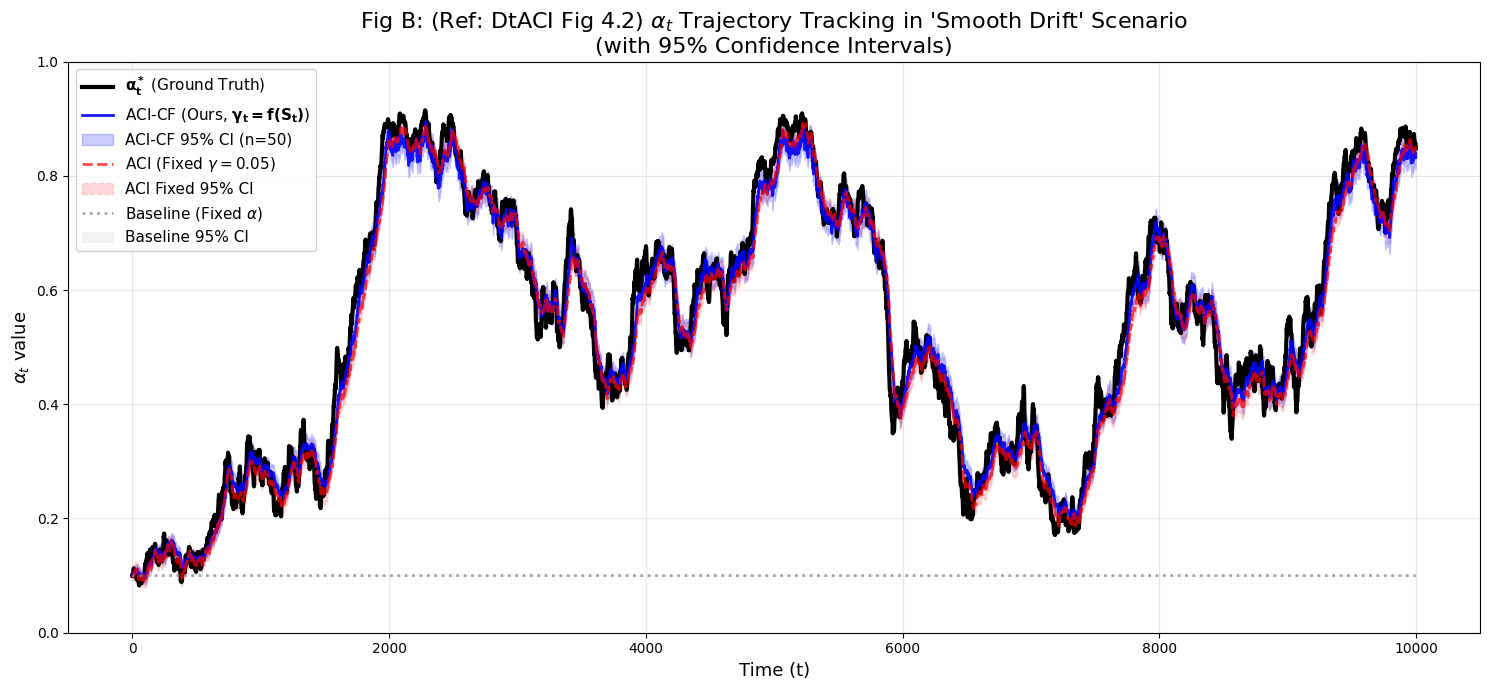

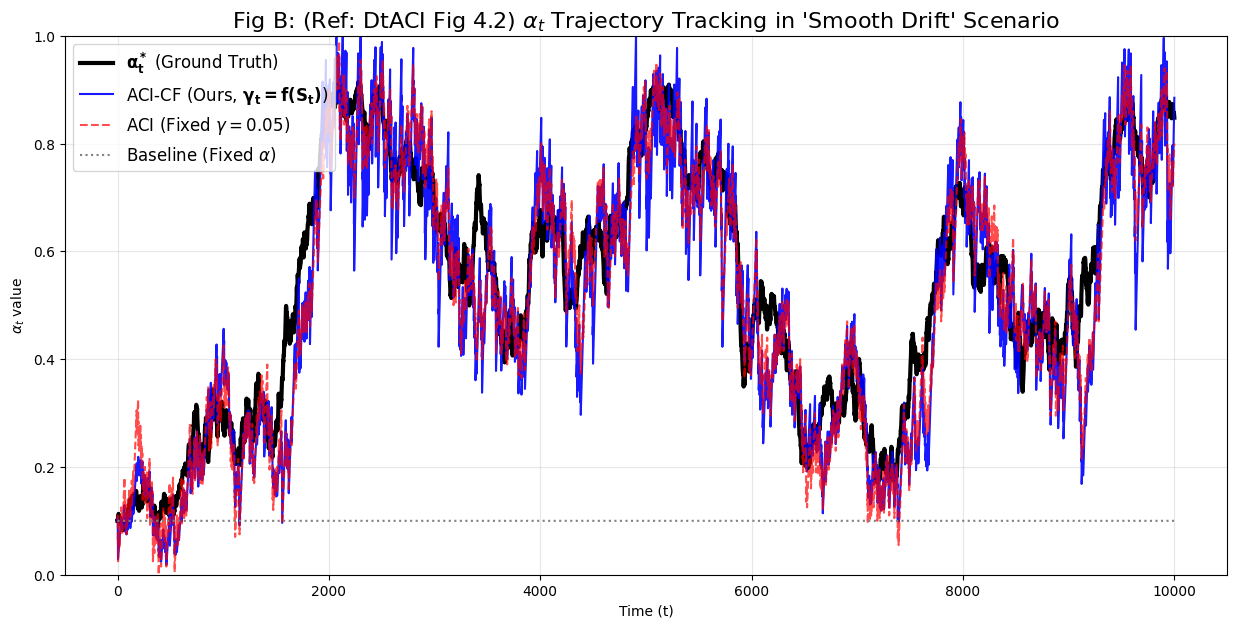

In [33]:
# --- "Money Plot": 追踪 α_t* ---
plt.figure(figsize=(15, 7))
plt.plot(alpha_star_trajectory, label="$\mathbf{\\alpha_t^*}$ (Ground Truth)", color='black', linewidth=3)
plt.plot(alpha_aci_ours, label="ACI-CF (Ours, $\mathbf{\gamma_t=f(S_t)}$)", color='blue', alpha=0.9)
plt.plot(alpha_aci_fixed, label=f"ACI (Fixed $\gamma={GAMMA_FIXED}$)", color='red', alpha=0.7, linestyle='--')
plt.plot(alpha_baseline, label="Baseline (Fixed $\\alpha$)", color='gray', linestyle=':')
plt.title("Fig B: (Ref: DtACI Fig 4.2) $\\alpha_t$ Trajectory Tracking in 'Smooth Drift' Scenario", fontsize=16)
plt.xlabel("Time (t)")
plt.ylabel("$\\alpha_t$ value")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)  # 确保y轴范围在[0,1]，因为alpha应该在[0,1]范围内
plt.show()

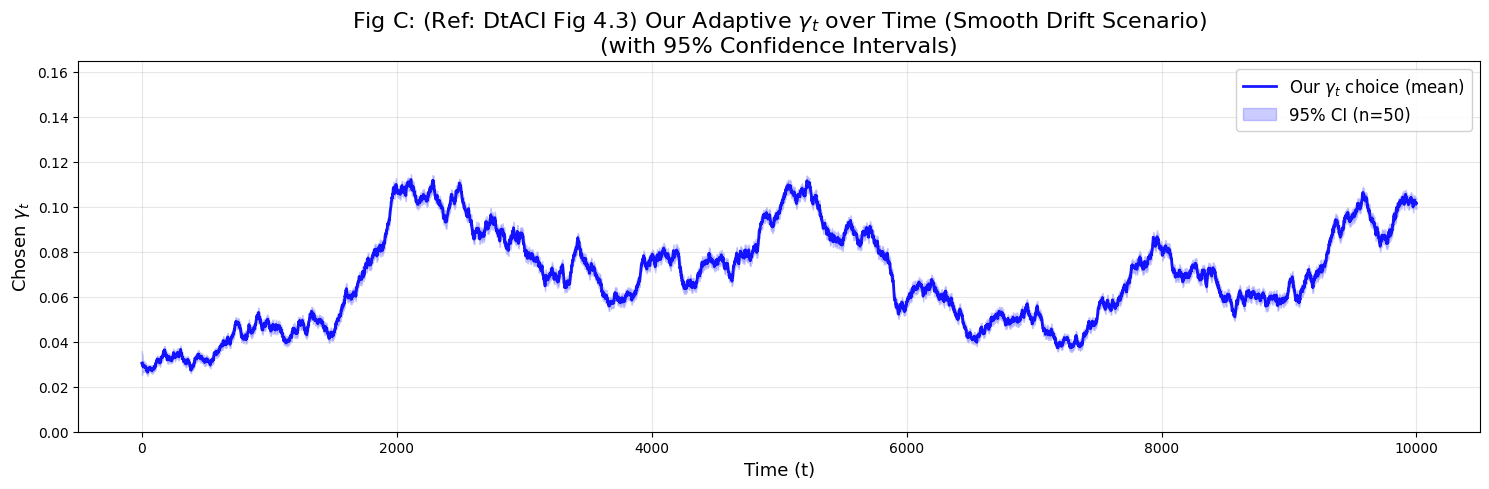

In [ ]:
# --- "Why Plot": 我们选择的 γ_t ---
plt.figure(figsize=(15, 5))
plt.plot(gamma_t_history, label="Our $\gamma_t$ choice", color='blue')
plt.title("Fig C: (Ref: DtACI Fig 4.3) Our Adaptive $\gamma_t$ over Time (Smooth Drift Scenario)", fontsize=16)
plt.xlabel("Time (t)")
plt.ylabel("Chosen $\gamma_t$")
plt.ylim(0, GAMMA_MAX * 1.1)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

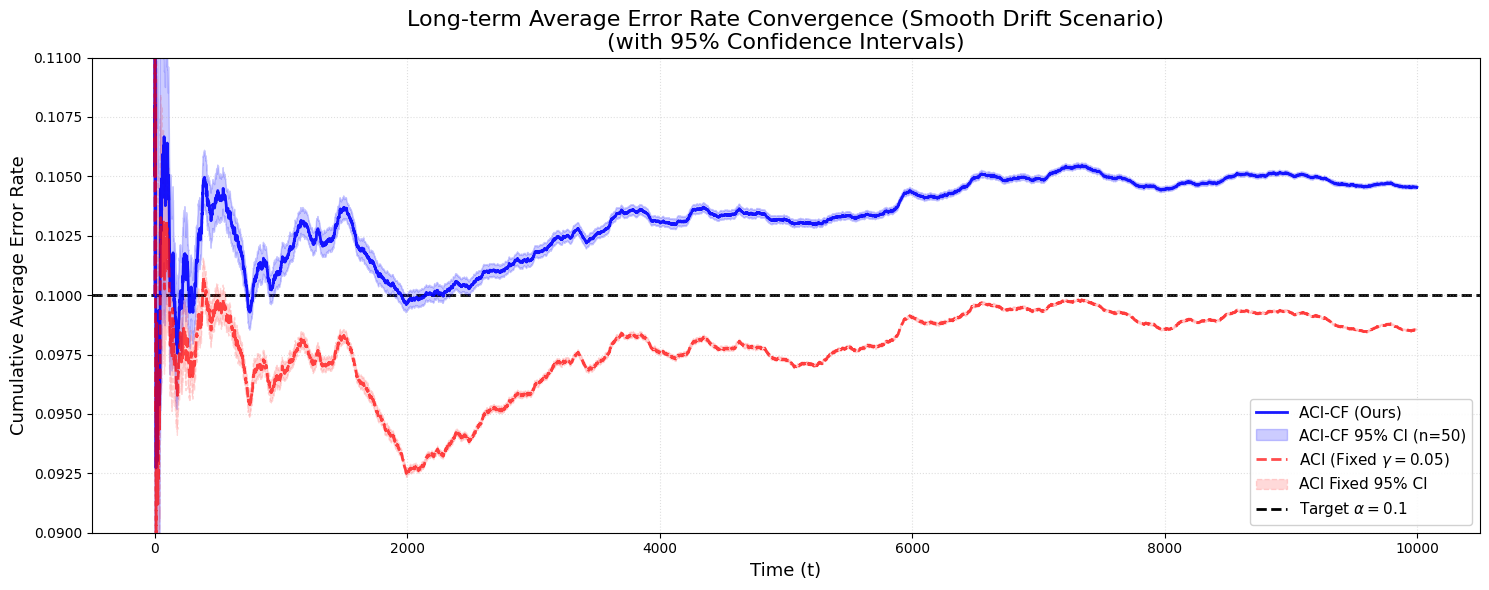

In [ ]:
# --- "Long-term Average Error Rate Convergence" ---
# 计算长期平均错误率（累积平均错误率）来对比收敛速度

# 将错误列表转换为numpy数组
err_baseline_arr = np.array(err_baseline)
err_aci_fixed_arr = np.array(err_aci_fixed)
err_aci_ours_arr = np.array(err_aci_ours)

# 计算累积平均错误率（从开始到当前时刻的平均）
def compute_cumulative_avg_error(err_array):
    """计算累积平均错误率"""
    cumulative_avg = np.zeros(len(err_array))
    for t in range(len(err_array)):
        cumulative_avg[t] = np.mean(err_array[0:t+1])
    return cumulative_avg

cumulative_avg_baseline = compute_cumulative_avg_error(err_baseline_arr)
cumulative_avg_aci_fixed = compute_cumulative_avg_error(err_aci_fixed_arr)
cumulative_avg_aci_ours = compute_cumulative_avg_error(err_aci_ours_arr)

# 绘图
plt.figure(figsize=(15, 6))
plt.plot(cumulative_avg_aci_ours, label="ACI-CF (Ours)", color='blue', linewidth=2, alpha=0.9)
plt.plot(cumulative_avg_aci_fixed, label=f"ACI (Fixed $\gamma={GAMMA_FIXED}$)", color='red', linewidth=2, alpha=0.7, linestyle='--')
# plt.plot(cumulative_avg_baseline, label="Baseline (Fixed $\\alpha$)", color='gray', linewidth=2, alpha=0.7, linestyle=':')
plt.axhline(TARGET_ALPHA, color='black', linestyle='--', linewidth=2, label=f'Target $\\alpha={TARGET_ALPHA}$', zorder=0)

plt.title("Long-term Average Error Rate Convergence (Smooth Drift Scenario)", fontsize=16)
plt.xlabel("Time (t)", fontsize=13)
plt.ylabel("Cumulative Average Error Rate", fontsize=13)
plt.legend(fontsize=12, framealpha=0.9)
plt.grid(True, linestyle=':', alpha=0.4)
plt.ylim(TARGET_ALPHA * 0.9, TARGET_ALPHA * 1.1)  # 设置合理的y轴范围
plt.tight_layout()
plt.show()

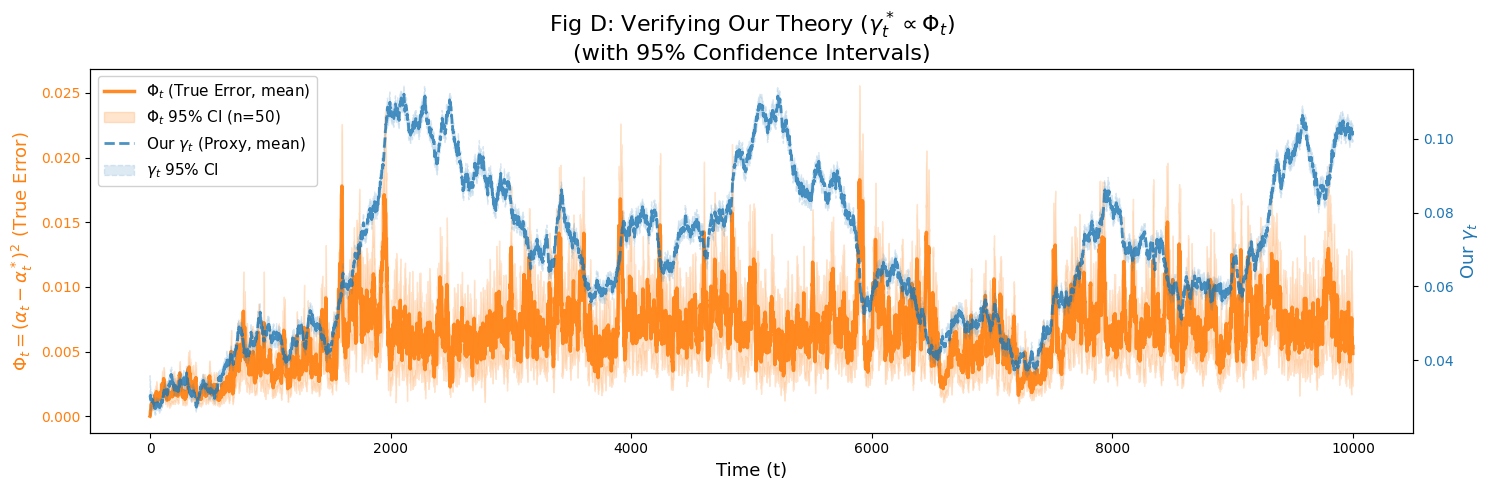

In [ ]:
# --- "Theory Plot": 验证 Φ_t 和 S_t (即 γ_t) 的关系 ---
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot 1: 真实的瞬时误差 Φ_t (黄线，更粗更明显)
color = 'tab:orange'
ax1.set_xlabel('Time (t)', fontsize=13)
ax1.set_ylabel('$\Phi_t = (\\alpha_t - \\alpha_t^*)^2$ (True Error)', color=color, fontsize=13)
ax1.plot(phi_t_history, color=color, alpha=0.9, linewidth=2.5, label='$\Phi_t$ (True Error)', zorder=3)
ax1.tick_params(axis='y', labelcolor=color)

# Plot 2: 我们的 γ_t (S_t 的代理) - 使用虚线以便区分
ax2 = ax1.twinx() # 共享 x 轴
color = 'tab:blue'
ax2.set_ylabel('Our $\gamma_t$', color=color, fontsize=13)
ax2.plot(gamma_t_history, color=color, linestyle='--', alpha=0.8, linewidth=2, label='Our $\gamma_t$ (Proxy)', zorder=2)
ax2.tick_params(axis='y', labelcolor=color)

# 添加图例（合并两个轴的图例）
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12, framealpha=0.9)

plt.title("Fig D: Verifying Our Theory ($\gamma_t^* \\propto \Phi_t$)", fontsize=16)
fig.tight_layout()
plt.show()

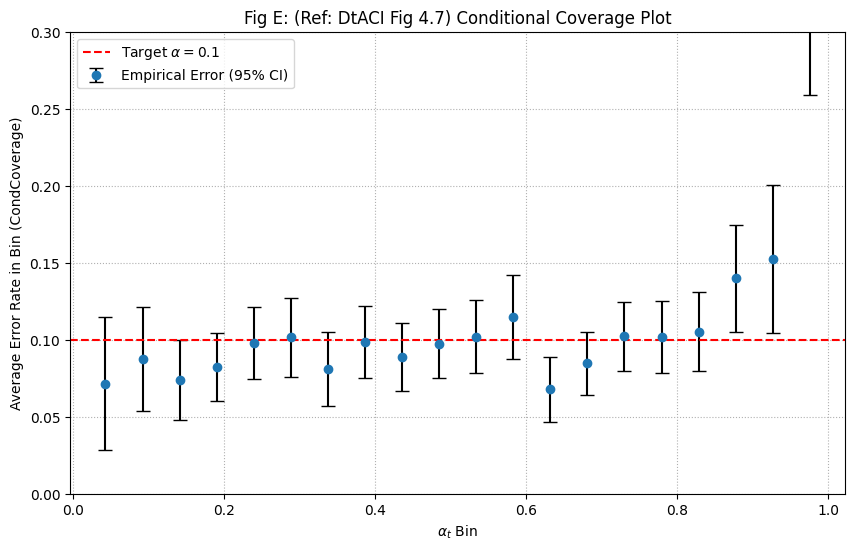

In [37]:
import scipy.stats as st

# --- "Stability Plot": 条件覆盖率 (Ref: Fig 4.7)  ---
df = pd.DataFrame({
    'alpha_t': alpha_aci_ours,
    'error': err_aci_ours
})

# 1. 将 α_t 分箱 (binning)
num_bins = 20
df['alpha_bin'] = pd.cut(df['alpha_t'], bins=num_bins)

# 2. 计算每个 bin 的统计数据（均值和样本数）
# 我们现在需要 "mean" 和 "count"
grouped = df.groupby('alpha_bin', observed=True)['error']
stats = grouped.agg(['mean', 'count'])

# 3. 计算 95% 置信区间 (95% CI)
# 这就是误差棒（error bars）
p = stats['mean']
n = stats['count']

# 伯努利分布的标准误差 Standard Error of the Mean (SEM)
# sem = sqrt(p * (1-p) / n)
sem = np.sqrt(p * (1 - p) / n)

# 95% CI 的 z-score (双边)
z_score = st.norm.ppf(0.975) # 约等于 1.96

# 误差棒的“半高度”
y_err = z_score * sem

# 准备绘图
bin_centers = [b.mid for b in stats.index]

# 4. 绘图 (使用 plt.errorbar)
plt.figure(figsize=(10, 6))

# 使用 plt.errorbar 绘制均值（红点）和误差棒（黑线）
# fmt='o' 表示用圆点标记均值
# capsize=5 绘制误差棒顶部的“帽子”
plt.errorbar(bin_centers, stats['mean'], yerr=y_err, fmt='o', color='C0',
             ecolor='black', capsize=5, label='Empirical Error (95% CI)')

plt.axhline(TARGET_ALPHA, color='red', linestyle='--', label=f'Target $\\alpha = {TARGET_ALPHA}$')

plt.xlabel("$\\alpha_t$ Bin")
plt.ylabel("Average Error Rate in Bin (CondCoverage)")
plt.title("Fig E: (Ref: DtACI Fig 4.7) Conditional Coverage Plot")
plt.legend()

# 设置 Y 轴范围，使其与 DtACI 论文中的图  具有可比性（他们截断了）
# 我们的目标是 0.1，所以我们以 0.1 为中心
plt.ylim(TARGET_ALPHA - 0.1, TARGET_ALPHA + 0.2) # 例如：[0.0, 0.3]
plt.grid(True, linestyle=':')
plt.show()

In [38]:
# import scipy.stats as st

# # --- "Stability Plot": 条件覆盖率 (Ref: Fig 4.7)  ---
# # 为三个方法分别创建DataFrame
# df_ours = pd.DataFrame({
#     'alpha_t': alpha_aci_ours,
#     'error': err_aci_ours
# })

# df_fixed = pd.DataFrame({
#     'alpha_t': alpha_aci_fixed,
#     'error': err_aci_fixed
# })

# df_baseline = pd.DataFrame({
#     'alpha_t': alpha_baseline,
#     'error': err_baseline
# })

# # 1. 将 α_t 分箱 (binning) - 使用所有方法的范围来确定统一的bins
# all_alpha = np.concatenate([alpha_aci_ours, alpha_aci_fixed, alpha_baseline])
# num_bins = 20
# alpha_min, alpha_max = all_alpha.min(), all_alpha.max()
# bins = np.linspace(alpha_min, alpha_max, num_bins + 1)

# df_ours['alpha_bin'] = pd.cut(df_ours['alpha_t'], bins=bins)
# df_fixed['alpha_bin'] = pd.cut(df_fixed['alpha_t'], bins=bins)
# df_baseline['alpha_bin'] = pd.cut(df_baseline['alpha_t'], bins=bins)

# # 2. 计算每个方法的统计数据（均值和样本数）
# def compute_stats(df):
#     grouped = df.groupby('alpha_bin', observed=True)['error']
#     stats = grouped.agg(['mean', 'count'])
#     p = stats['mean']
#     n = stats['count']
#     sem = np.sqrt(p * (1 - p) / n)
#     z_score = st.norm.ppf(0.975)
#     y_err = z_score * sem
#     bin_centers = [b.mid for b in stats.index]
#     return stats, bin_centers, y_err

# stats_ours, bin_centers_ours, y_err_ours = compute_stats(df_ours)
# stats_fixed, bin_centers_fixed, y_err_fixed = compute_stats(df_fixed)
# stats_baseline, bin_centers_baseline, y_err_baseline = compute_stats(df_baseline)

# # 3. 绘图 (使用 plt.errorbar + 连接线)
# plt.figure(figsize=(12, 7))

# # 绘制三个方法的errorbar，添加连接线以增强区分度
# # ACI-CF (Ours) - 蓝色，实线，圆点
# plt.errorbar(bin_centers_ours, stats_ours['mean'], yerr=y_err_ours, 
#              fmt='o-', color='#1f77b4', ecolor='#1f77b4', capsize=5, 
#              alpha=0.8, label='ACI-CF (Ours)', markersize=8, 
#              linewidth=2.5, markeredgewidth=1.5, markeredgecolor='white')

# # ACI (Fixed γ) - 红色，虚线，方块
# plt.errorbar(bin_centers_fixed, stats_fixed['mean'], yerr=y_err_fixed, 
#              fmt='s--', color='#d62728', ecolor='#d62728', capsize=5, 
#              alpha=0.8, label=f'ACI (Fixed $\gamma={GAMMA_FIXED}$)', markersize=8,
#              linewidth=2.5, markeredgewidth=1.5, markeredgecolor='white')

# # Baseline (Fixed α) - 灰色，点线，三角
# plt.errorbar(bin_centers_baseline, stats_baseline['mean'], yerr=y_err_baseline, 
#              fmt='^:', color='#7f7f7f', ecolor='#7f7f7f', capsize=5, 
#              alpha=0.8, label='Baseline (Fixed $\/alpha$)', markersize=9,
#              linewidth=2.5, markeredgewidth=1.5, markeredgecolor='white')

# plt.axhline(TARGET_ALPHA, color='black', linestyle='--', linewidth=2, 
#             label=f'Target $\/alpha = {TARGET_ALPHA}$', zorder=0)

# plt.xlabel("$\/alpha_t$ Bin", fontsize=13)
# plt.ylabel("Average Error Rate in Bin (CondCoverage)", fontsize=13)
# plt.title("Fig E: (Ref: DtACI Fig 4.7) Conditional Coverage Plot", fontsize=15, fontweight='bold')
# plt.legend(fontsize=12, framealpha=0.9, loc='best')

# # 设置 Y 轴范围，使其与 DtACI 论文中的图具有可比性（他们截断了）
# plt.ylim(TARGET_ALPHA - 0.1, TARGET_ALPHA + 0.2)
# plt.grid(True, linestyle=':', alpha=0.4, linewidth=0.8)
# plt.tight_layout()
# plt.show()